In [4]:
import time

import torch
from scripts import load_dataset
from scripts.encoder_model_wrapper import T5EncoderClassifier
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    precision_score,
    recall_score,
)
from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    DataCollatorForSeq2Seq,
    GenerationConfig,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
)

# T5 Base Evaluation

In [6]:
_, test_ds = load_dataset.load_dataset(
    "../../../../German_newspaper_articles/10kGNAD/train.csv",
    "../../../../German_newspaper_articles/10kGNAD/test.csv",
)

In [7]:
CATEGORY_FORMAT = "Klassifiziere nachfolgenden Artikel in eine der folgendenen Kategorien: Web, International, Etat, Wirtschaft, Panorama, Sport, Wissenschaft, Kultur oder Inland:\n"
test_ds = test_ds.map(lambda x: {"text": CATEGORY_FORMAT + x["text"]})

Map:   0%|          | 0/1028 [00:00<?, ? examples/s]

In [8]:
model = AutoModelForSeq2SeqLM.from_pretrained(
    "../../../results/t5_results/base/model.nosync"
)
generation_config = GenerationConfig.from_pretrained(
    "google-t5/t5-base", max_new_tokens=5
)
model.generation_config = generation_config
model.generation_config
tokenizer = AutoTokenizer.from_pretrained("google-t5/t5-base")
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer)

/Users/Malte/Documents/Technische Informatik /Forschungsprojekt/TextClassifier/.venv.nosync/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [10]:
test_ds = test_ds.map(
    lambda x: tokenizer(
        x["text"], truncation=True, padding="max_length", max_length=512
    )
)
test_ds = test_ds.map(
    lambda y: {
        "labels": tokenizer(
            y["label"], truncation=True, padding="max_length", max_length=5
        )["input_ids"]
    }
).remove_columns("label")

Map:   0%|          | 0/1028 [00:00<?, ? examples/s]

Map:   0%|          | 0/1028 [00:00<?, ? examples/s]

In [11]:
def compute_metrics(eval_preds):
    preds, eval = eval_preds
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(eval, skip_special_tokens=True)
    label_ids = [
        load_dataset.label_to_id[decoded_label] for decoded_label in decoded_labels
    ]
    pred_ids = []
    for decoded_pred in decoded_preds:
        if decoded_pred in load_dataset.label_to_id:
            pred_ids.append(load_dataset.label_to_id[decoded_pred])
        else:
            pred_ids.append(-1)

    labels = [
        "Web",
        "International",
        "Etat",
        "Wirtschaft",
        "Panorama",
        "Sport",
        "Wissenschaft",
        "Kultur",
        "Inland",
    ]
    ConfusionMatrixDisplay.from_predictions(
        label_ids, pred_ids, display_labels=labels, xticks_rotation="vertical"
    )
    return {
        "accuracy": accuracy_score(label_ids, pred_ids),
        "balanced_accuracy": balanced_accuracy_score(label_ids, pred_ids),
        "precision_macro": precision_score(label_ids, pred_ids, average="macro"),
        "precision_micro": precision_score(label_ids, pred_ids, average="micro"),
        "recall_macro": recall_score(label_ids, pred_ids, average="macro"),
        "recall_micro": recall_score(label_ids, pred_ids, average="micro"),
        "f1_micro": f1_score(label_ids, pred_ids, average="micro"),
        "f1_macro": f1_score(label_ids, pred_ids, average="macro"),
    }

In [15]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    predict_with_generate=True,
)

In [16]:
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

/Users/Malte/Documents/Technische Informatik /Forschungsprojekt/TextClassifier/.venv.nosync/lib/python3.11/site-packages/accelerate/accelerator.py:447: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


In [ ]:
trainer.evaluate(eval_dataset=test_ds.with_format("torch"))

# T5 Encoder Evaluation

In [2]:
_, test_ds = load_dataset.load_dataset(
    "../../../../German_newspaper_articles/10kGNAD/train.csv",
    "../../../../German_newspaper_articles/10kGNAD/test.csv",
)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
device = "mps"  # For mac
model: T5EncoderClassifier = torch.load(
    "../../../results/t5_results/encoder/model.nosync/model.pt", map_location=device
)

Using device: cpu


In [8]:
def tokenize_function(examples):
    return model.tokenizer(
        examples["text"], padding="max_length", max_length=512, truncation=True
    )

In [9]:
test_ds = test_ds.map(tokenize_function)

Map:   0%|          | 0/1028 [00:00<?, ? examples/s]

In [10]:
test_ds = test_ds.map(load_dataset.add_label_id)

Map:   0%|          | 0/1028 [00:00<?, ? examples/s]

In [11]:
y_true = []
y_pred = []
wrong = []


def test():
    model.eval()
    test_ds.set_format("torch", device=device)
    start_time = time.perf_counter()
    for data in test_ds:
        label_id = torch.unsqueeze(data["label_id"], 0)

        output = model(
            torch.unsqueeze(data["input_ids"], 0),
            torch.unsqueeze(data["attention_mask"], 0),
        )
        output = torch.argmax(output)

        global y_true
        global y_pred
        y_true.append(label_id.item())
        y_pred.append(output.item())

        if label_id.item() is not output.item():
            global wrong
            item = {
                "text": data["text"],
                "prediction": load_dataset.id_to_label[output.item()],
                "label": data["label"],
            }
            wrong.append(item)
    end_time = time.perf_counter()
    print(f"Test took {(end_time - start_time)/60:0.4f} minutes")

In [12]:
test()

Test took 2.6725 minutes


In [13]:
metrics = {
    "accuracy": accuracy_score(y_true, y_pred),
    "balanced_accuracy": balanced_accuracy_score(y_true, y_pred),
    "precision_macro": precision_score(y_true, y_pred, average="macro"),
    "precision_micro": precision_score(y_true, y_pred, average="micro"),
    "recall_macro": recall_score(y_true, y_pred, average="macro"),
    "recall_micro": recall_score(y_true, y_pred, average="micro"),
    "f1_micro": f1_score(y_true, y_pred, average="micro"),
    "f1_macro": f1_score(y_true, y_pred, average="macro"),
}
metrics

{'accuracy': 0.9027237354085603,
 'balanced_accuracy': 0.9046010357808828,
 'precision_macro': 0.8979239746568471,
 'precision_micro': 0.9027237354085603,
 'recall_macro': 0.9046010357808828,
 'recall_micro': 0.9027237354085603,
 'f1_micro': 0.9027237354085603,
 'f1_macro': 0.9006855113555177}

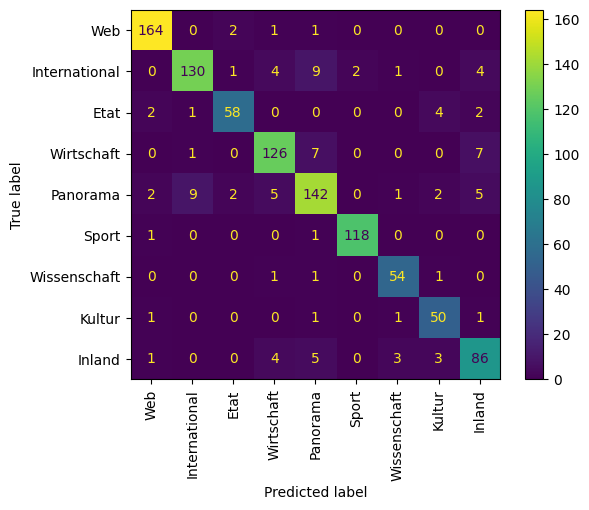

In [14]:
labels = [
    "Web",
    "International",
    "Etat",
    "Wirtschaft",
    "Panorama",
    "Sport",
    "Wissenschaft",
    "Kultur",
    "Inland",
]
disp = ConfusionMatrixDisplay.from_predictions(
    y_true, y_pred, display_labels=labels, xticks_rotation="vertical"
)